# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

## Load Data

In [2]:
df = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Let's check the number of movies and reviews over years.

<AxesSubplot:xlabel='review_length', ylabel='Count'>

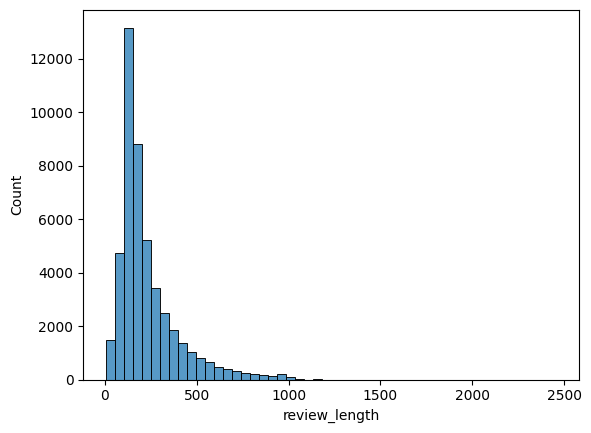

In [4]:
df['pos'].value_counts(normalize=True)  # Class distribution
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['review_length'].describe()

sns.histplot(df['review_length'], bins=50)

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

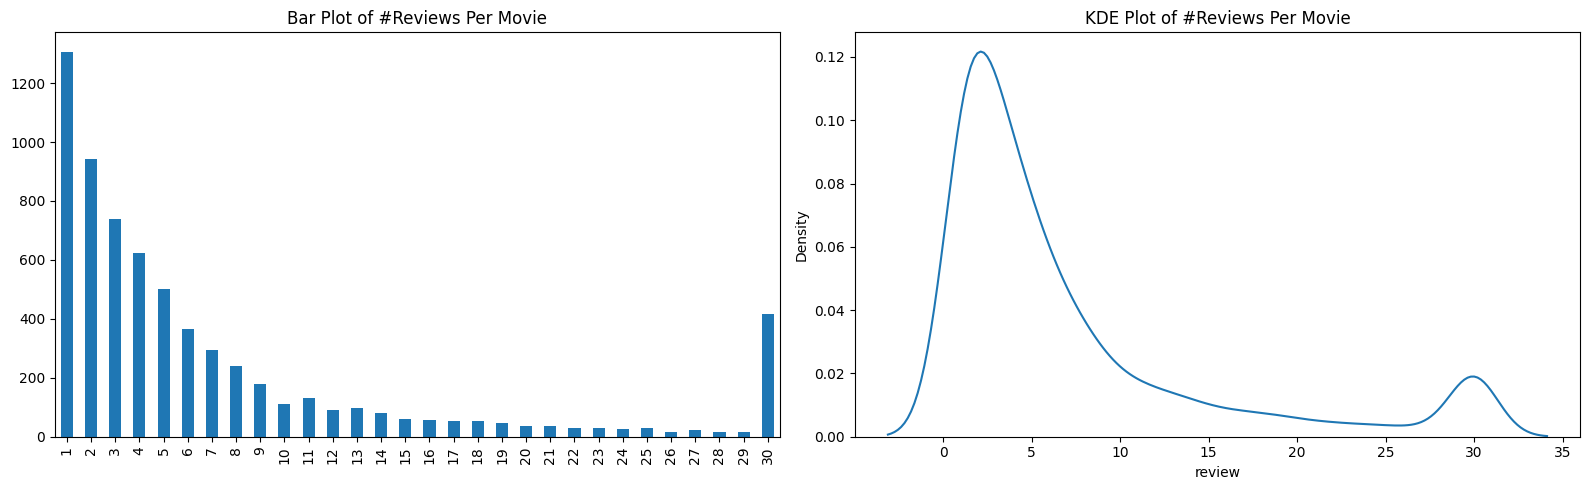

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [6]:
df['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

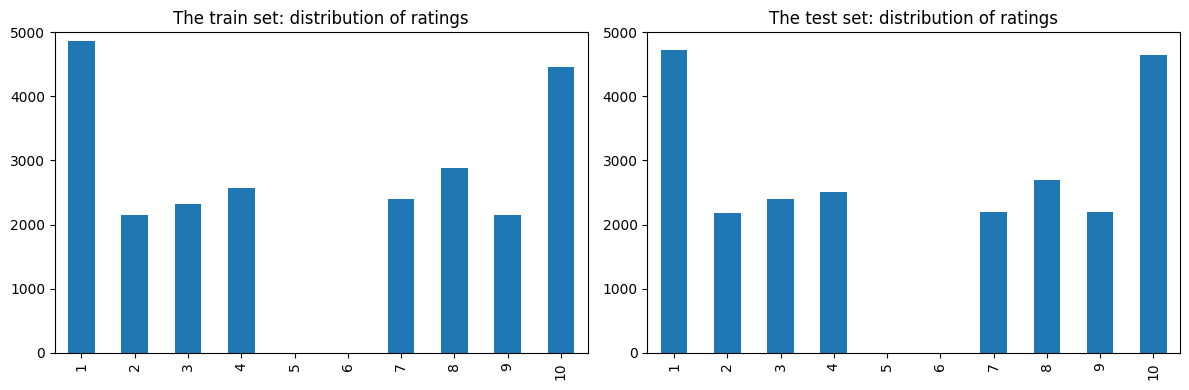

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


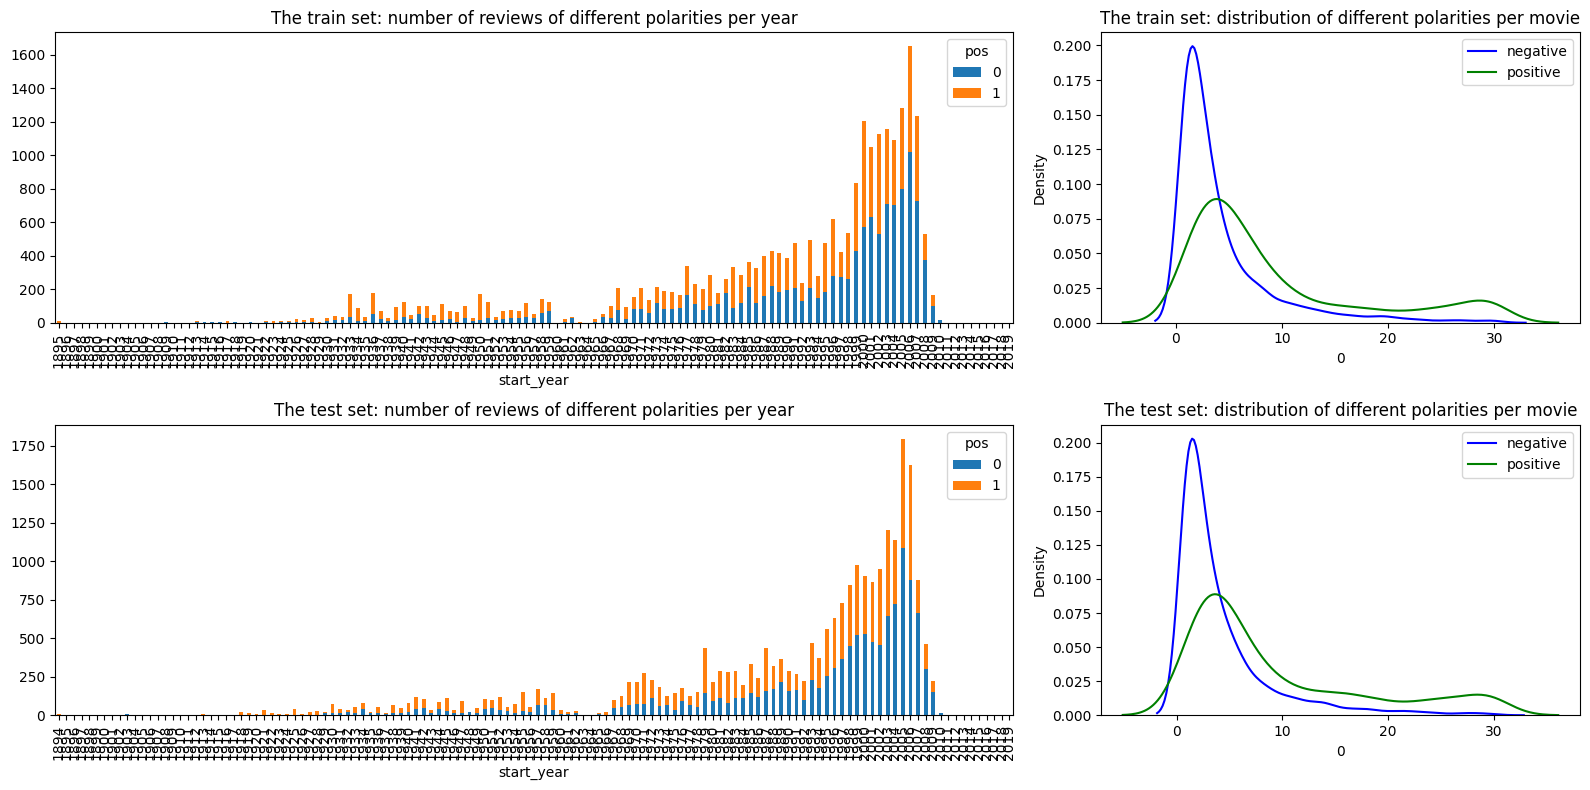

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [9]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [10]:
import re
df['review_norm'] =  df['review'].apply(
    lambda x: re.sub(r'[^a-z\s]', '', x.lower()))

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [11]:
df_train = df.query('ds_part == "train"').copy()
df_test = df.query('ds_part == "test"').copy()

train_target = df_train['pos']
test_target = df_test['pos']

print(df_train.shape)
print(df_test.shape)

(23796, 19)
(23535, 19)


## Working with models

### Model 0 - Constant

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

In [13]:
# Create the model — strategy="most_frequent" means it will always predict the majority class
model_0 = DummyClassifier(strategy="most_frequent")

# Train (fit) on the training set
model_0.fit(df_train, train_target)

# Predict on the test set
pred_0 = model_0.predict(df_test)

# Evaluate F1 score
f1_0 = f1_score(test_target, pred_0)

print(f"Model 0 (Constant) F1 Score: {f1_0:.4f}")

Model 0 (Constant) F1 Score: 0.0000


### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [14]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [15]:
stop_words = stopwords.words('english')
vectorizer_1 = TfidfVectorizer(lowercase=True, stop_words=stop_words, max_features=5000)
train_features_1 = vectorizer_1.fit_transform(df_train['review_norm'])
test_features_1 = vectorizer_1.transform(df_test['review_norm'])

In [16]:
model_1 = LogisticRegression(max_iter=1000, random_state=12345)
model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000, random_state=12345)

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


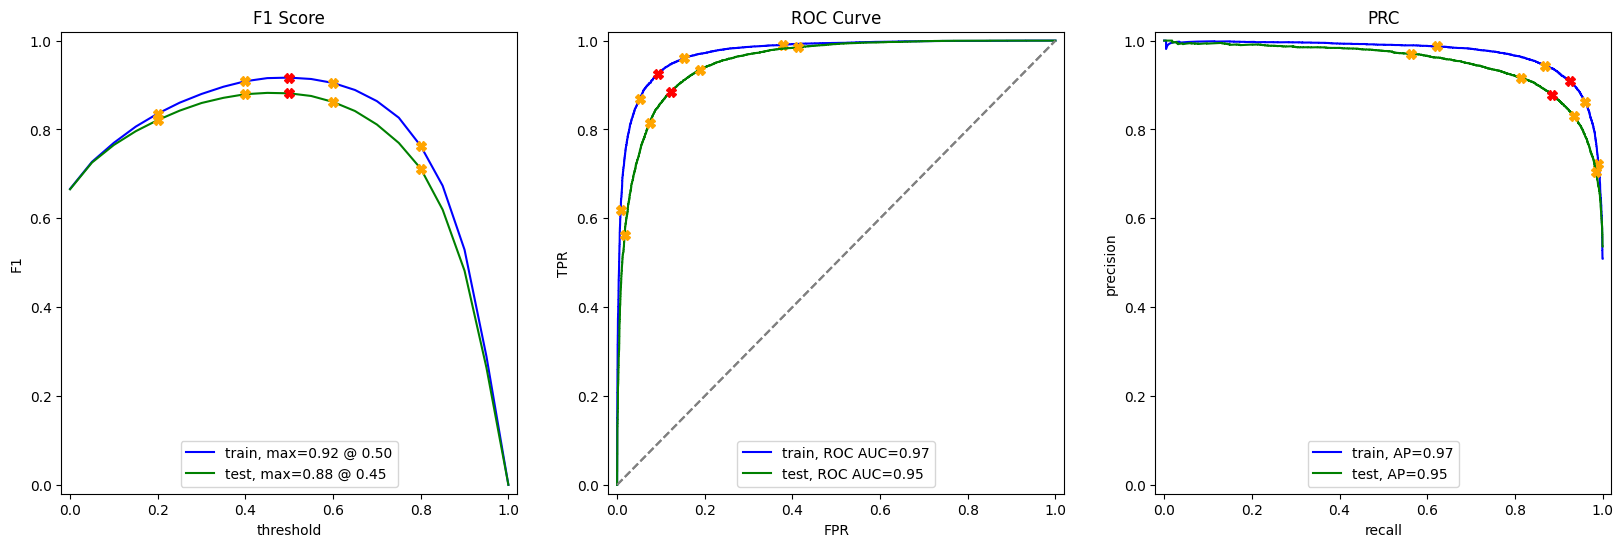

In [17]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [18]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [19]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [20]:
# Apply preprocessing to train and test
train_texts_3 = df_train['review_norm'].apply(text_preprocessing_3)
test_texts_3 = df_test['review_norm'].apply(text_preprocessing_3)

In [21]:
# TF-IDF Vectorizer
vectorizer_3 = TfidfVectorizer(max_features=5000)
train_features_3 = vectorizer_3.fit_transform(train_texts_3)
test_features_3 = vectorizer_3.transform(test_texts_3)

In [22]:
# Model
model_3 = LogisticRegression(max_iter=1000, random_state=12345)
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000, random_state=12345)

          train  test
Accuracy   0.91  0.88
F1         0.91  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


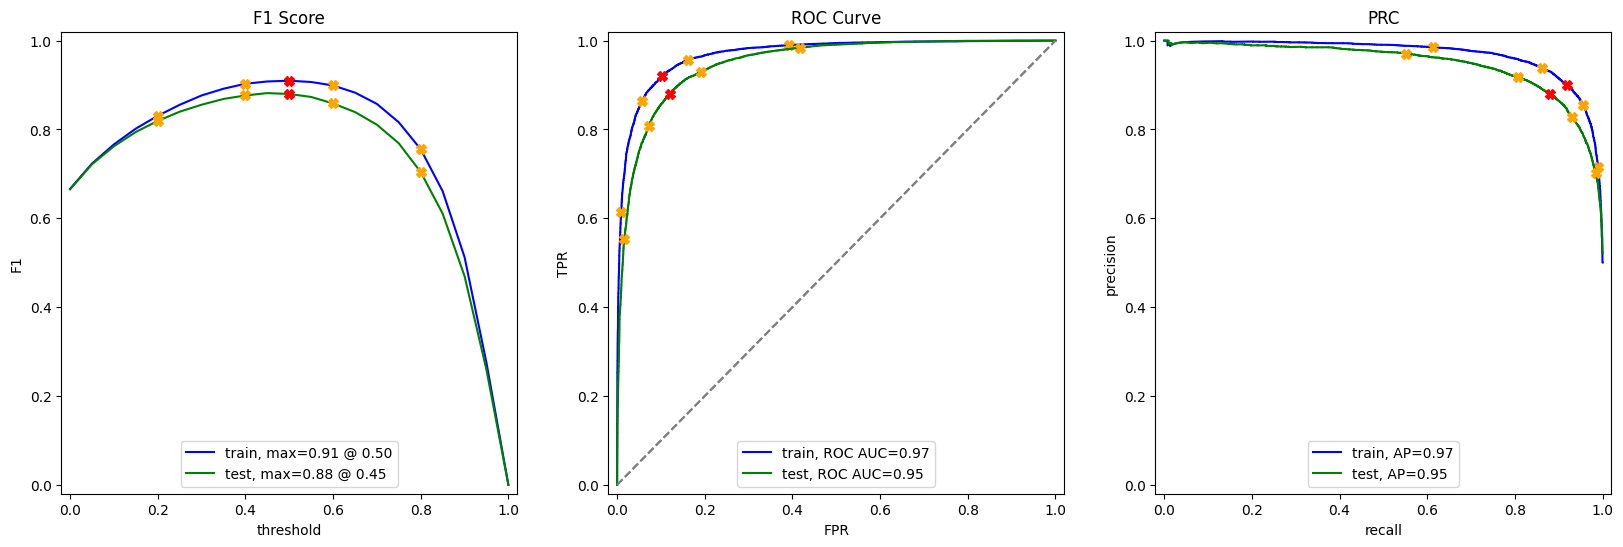

In [23]:
# Evaluate
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [24]:
from lightgbm import LGBMClassifier

In [25]:
# Preprocessing stays same as Model 3
train_texts_4 = df_train['review_norm'].apply(text_preprocessing_3)
test_texts_4 = df_test['review_norm'].apply(text_preprocessing_3)

# TF-IDF
vectorizer_4 = TfidfVectorizer(max_features=5000)
train_features_4 = vectorizer_4.fit_transform(train_texts_4)
test_features_4 = vectorizer_4.transform(test_texts_4)


In [26]:
# LightGBM Classifier
model_4 = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=12345
)
model_4.fit(train_features_4, train_target)

LGBMClassifier(learning_rate=0.05, n_estimators=500, random_state=12345)

          train  test
Accuracy   0.98  0.87
F1         0.98  0.87
APS        1.00  0.94
ROC AUC    1.00  0.95


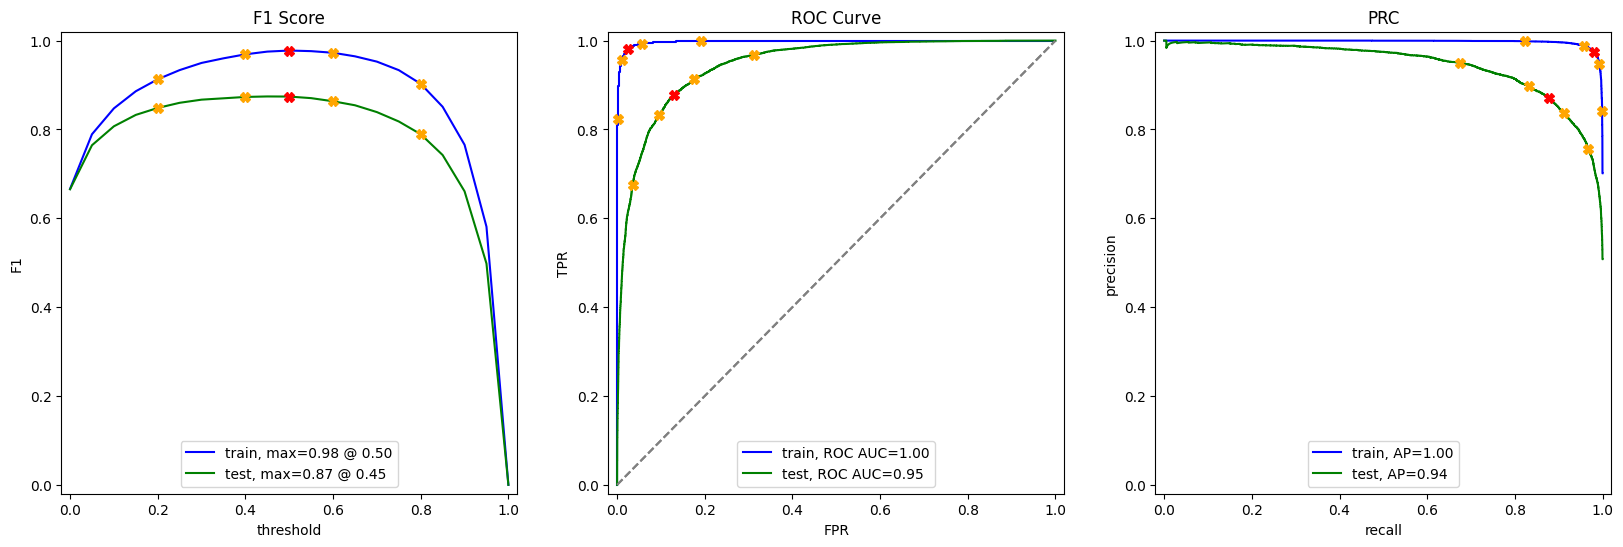

In [27]:
# Evaluate
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

###  Model 9 - BERT

In [28]:
# import torch
# import transformers

In [29]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [30]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#     ids_list = []
#     attention_mask_list = []

#     # text to padded ids of tokens along with their attention masks
    
#     # <put your code here to create ids_list and attention_mask_list>
    
#     # Tokenize & pad
#     for text in texts:
#         encoded = tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,
#             max_length=max_length,
#             truncation=True,
#             padding='max_length',   # pad to max_length
#             return_attention_mask=True
#         )
#         ids_list.append(encoded['input_ids'])
#         attention_mask_list.append(encoded['attention_mask'])
    
#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#     model.to(device)
#     if not disable_progress_bar:
#         print(f'Using the {device} device.')
    
#     # gettings embeddings in batches

#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#         ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#         attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
#         with torch.no_grad():            
#             model.eval()
#             batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#         embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#     return np.concatenate(embeddings)

In [31]:
# # Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [32]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [33]:

# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']


  Good to skip BERT in this environment , it’s not strictly required for meeting the project goals the current TF-IDF + Logistic Regression and LightGBM approaches already achieve strong performance efficiently. If we wish to explore BERT later, platforms like Google Colab or Kaggle with GPU enabled are great options

## My Reviews

In [34]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(text_preprocessing_3)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.","I do not simply like it , not my kind of movie ."
1,"Well, I was bored and felt asleep in the middl...","well , I be bored and feel asleep in the middl..."
2,I was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,I do not expect the reboot to be so good ! wri...
5,"The movie had its upsides and downsides, but I...","the movie have its upside and downside , but I..."
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy . not a sing...
7,Launching on Netflix was a brave move & I real...,launch on Netflix be a brave move & I really a...


### Model 2

In [35]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  I do not simply like it , not my kind of movie .
0.27:  well , I be bored and feel asleep in the middle of the movie .
0.60:  I be really fascinated with the movie
0.20:  even the actor look really old and disinterested , and they get pay to be in the movie . what a soul
0.30:  I do not expect the reboot to be so good ! writer really care about the source material
0.57:  the movie have its upside and downside , but I feel like overall it be a decent flick . I could see 
0.04:  what a rotten attempt at a comedy . not a single joke land , everyone act annoying and loud , even k
0.91:  launch on Netflix be a brave move & I really appreciate be able to binge on episode after episode , 


### Model 3

In [36]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.18:  I do not simply like it , not my kind of movie .
0.18:  well , I be bored and feel asleep in the middle of the movie .
0.51:  I be really fascinated with the movie
0.12:  even the actor look really old and disinterested , and they get pay to be in the movie . what a soul
0.15:  I do not expect the reboot to be so good ! writer really care about the source material
0.71:  the movie have its upside and downside , but I feel like overall it be a decent flick . I could see 
0.04:  what a rotten attempt at a comedy . not a single joke land , everyone act annoying and loud , even k
0.92:  launch on Netflix be a brave move & I really appreciate be able to binge on episode after episode , 


### Model 4

In [37]:
texts = my_reviews['review_norm']

vectorizer_4 = vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:  I do not simply like it , not my kind of movie .
0.36:  well , I be bored and feel asleep in the middle of the movie .
0.69:  I be really fascinated with the movie
0.56:  even the actor look really old and disinterested , and they get pay to be in the movie . what a soul
0.25:  I do not expect the reboot to be so good ! writer really care about the source material
0.87:  the movie have its upside and downside , but I feel like overall it be a decent flick . I could see 
0.19:  what a rotten attempt at a comedy . not a single joke land , everyone act annoying and loud , even k
0.92:  launch on Netflix be a brave move & I really appreciate be able to binge on episode after episode , 


### Model 9

In [39]:
# #texts = my_reviews['review_norm']

# #my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# for i, review in enumerate(texts.str.slice(0, 100)):
#      print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

**In this project, we tested several approaches for sentiment classification, ranging from a simple constant baseline to advanced machine learning models using text preprocessing techniques and TF-IDF features.**

- **Model 0 (Baseline Constant Classifier):**
The constant model achieved an F1 score of 0.0000, confirming that meaningful preprocessing and modeling are required for this task.

- **Model 1 (TF-IDF + Logistic Regression with NLTK preprocessing):**
Achieved an F1 score of 0.88 on the test set, with strong results across all metrics (Accuracy = 0.88, APS = 0.95, ROC AUC = 0.95). This demonstrates that TF-IDF combined with traditional machine learning is already highly effective.


- **Model 3 (spaCy preprocessing + Logistic Regression):**
Produced very similar results to Model 1, with an F1 score of 0.88 on the test set. This suggests that both NLTK and spaCy tokenization/lemmatization pipelines are effective, and neither clearly outperforms the other in this case.


- **Model 4 (spaCy + TF-IDF + LGBMClassifier):**
Achieved the highest training performance (F1 = 0.98), but its test performance dropped slightly to 0.87. While still strong, this indicates some degree of overfitting compared to Logistic Regression.


**Project Target**
The project target of F1 ≥ 0.85 on the test set was successfully achieved by all main models (Models 1, 3, and 4).

**Key Insights**

- Both NLTK and spaCy preprocessing pipelines led to nearly identical results, suggesting that for this dataset, the choice of preprocessing library has limited impact.
- Logistic Regression with TF-IDF (Model 1) strikes the best balance between performance and generalization, achieving high accuracy and F1 without signs of overfitting.
- LGBMClassifier (Model 4) shows very high training performance but slightly weaker generalization, meaning it may not be as stable in production unless regularization or further tuning is applied.
  
**Recommended Model for Deployment**
Based on the evaluation, Model 1 (TF-IDF + Logistic Regression) is the most suitable for deployment. It provides:
- Reliable performance (F1 = 0.88) above the project target.
- Strong generalization across metrics (ROC AUC = 0.95).
- Computational efficiency — faster training and inference compared to ensemble methods like LGBM.
  
Overall, the Logistic Regression model offers a balance of high accuracy, stability, and efficiency, making it the best candidate for real-world deployment.

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions